# Time-series outlier detection using Prophet on weather data

## Method

The Prophet outlier detector uses the [Prophet](https://facebook.github.io/prophet/) time series forecasting package explained in [this excellent paper](https://peerj.com/preprints/3190/). The underlying Prophet model is a decomposable univariate time series model combining trend, seasonality and holiday effects. The model forecast also includes an uncertainty interval around the estimated trend component using the [MAP estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) of the extrapolated model. Alternatively, full Bayesian inference can be done at the expense of increased compute. The upper and lower values of the uncertainty interval can then be used as outlier thresholds for each point in time. First, the distance from the observed value to the nearest uncertainty boundary (upper or lower) is computed. If the observation is within the boundaries, the outlier score equals the negative distance. As a result, the outlier score is the lowest when the observation equals the model prediction. If the observation is outside of the boundaries, the score equals the distance measure and the observation is flagged as an outlier. One of the main drawbacks of the method however is that you need to refit the model as new data comes in. This is undesirable for applications with high throughput and real-time detection.

## Dataset

The example uses a weather time series dataset recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/). The dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. Like the [TensorFlow time-series tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series), we only use data collected between 2009 and 2016.

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from datetime import datetime

# from alibi_detect.od import OutlierProphet
# from alibi_detect.utils.fetching import fetch_detector
# from alibi_detect.utils.saving import save_detector, load_detector

## Preprocess log file 

In [131]:
log_df = pd.read_csv('data/413377922610_elasticloadbalancing_us-east-1_prod_20200703T0958Z_54.243.202.15_3acrxxhj.log', sep=' ', header=None, encoding='utf-8')
log_df.columns = [
            'timestamp',
            'elb',
            'client',
            'backend',
            'request_processing_time',
            'backend_processing_time',
            'response_processing_time',
            'elb_status_code',
            'backend_status_code',
            'received_bytes',
            'sent_bytes',
            'ssl_cipher',
            'ssl_protocol',
            'request',
            'user_agent'
        ]

In [132]:
rescale_df = log_df.filter(['timestamp', 'backend_processing_time'], axis=1)


In [133]:
rescale_df['timestamp'] = rescale_df['timestamp'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))

# Preprocess Anomaly log file

In [134]:
anomaly_log_df = pd.read_csv('data/anomalyDateTime.csv', sep=' ', header=None, encoding='utf-8')
anomaly_log_df.columns = [
            'timestamp',
            'elb',
            'client',
            'backend',
            'request_processing_time',
            'backend_processing_time',
            'response_processing_time',
            'elb_status_code',
            'backend_status_code',
            'received_bytes',
            'sent_bytes',
            'ssl_cipher',
            'ssl_protocol',
            'request',
            'user_agent'
        ]

In [135]:
filter_anomaly_log_df              = anomaly_log_df.filter(['timestamp', 'backend_processing_time'], axis=1)
filter_anomaly_log_df['timestamp'] = filter_anomaly_log_df['timestamp'].apply(lambda x: (datetime.strptime((x), '%Y-%m-%dT%H:%M:%S.%fZ')))
filter_anomaly_log_df.shape

(1509, 2)

In [136]:
filter_anomaly_log_df.index    = filter_anomaly_log_df.timestamp
filter_anomaly_log_df_resample = filter_anomaly_log_df.resample('M', on='timestamp').mean()
filter_anomaly_log_df_resample['timestamp'] = filter_anomaly_log_df_resample.index
filter_anomaly_log_df_resample.reset_index(drop=True, inplace=True)
filter_anomaly_log_df_resample['timestamp']= filter_anomaly_log_df_resample['timestamp'].apply(lambda x: str(datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')))
filter_anomaly_log_df_resample

,backend_processing_time,timestamp
0,94095.625000,2019-04-30 00:00:00
1,NaN,2019-05-31 00:00:00
2,NaN,2019-06-30 00:00:00
3,93965.854369,2019-07-31 00:00:00
4,NaN,2019-08-31 00:00:00
5,NaN,2019-09-30 00:00:00
6,96796.956522,2019-10-31 00:00:00
7,95451.923077,2019-11-30 00:00:00


## Load dataset

In [137]:
df_1 = rescale_df
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'], format="%Y-%m-%dT%H:%M:%S")
# df_1.index = df_1.timestamp
df_2 = df_1.resample('M', on='timestamp').mean()
df_2['timestamp'] = df_2.index
df_2.to_csv('train.csv')
df_2.head()

,backend_processing_time,timestamp
timestamp,,
2019-01-31,20983.870968,2019-01-31
2019-02-28,20988.950893,2019-02-28
2019-03-31,20974.373880,2019-03-31
2019-04-30,21115.997851,2019-04-30
2019-05-31,20993.767921,2019-05-31


In [138]:
df = pd.read_csv('train.csv', index_col=None)
df.drop(['timestamp.1'],axis = 1, inplace = True)

In [139]:
df.head()

,timestamp,backend_processing_time
0,2019-01-31,20983.870968
1,2019-02-28,20988.950893
2,2019-03-31,20974.373880
3,2019-04-30,21115.997851
4,2019-05-31,20993.767921


Select subset to test Prophet model on:

In [140]:
n_prophet = 34040

Prophet model expects a DataFrame with 2 columns: one named ```ds``` with the timestamps and one named ```y``` with the time series to be evaluated. We will just look at the temperature data:

In [141]:
d = {'ds': df['timestamp'][:n_prophet], 'y': df['backend_processing_time'][:n_prophet]}
df_T = pd.DataFrame(data=d)
print(df_T.shape)
#df_T.head()

df_T.tail()

(12, 2)


,ds,y
7,2019-08-31,20975.001568
8,2019-09-30,20974.463657
9,2019-10-31,20990.741417
10,2019-11-30,21233.995179
11,2019-12-31,20997.809812


In [142]:
filter_anomaly_log_df_resample.shape

(8, 2)

In [143]:
df_T = df_T.loc[df_T['y'] < 30000]

In [128]:
y_max = df_T['y'].max()

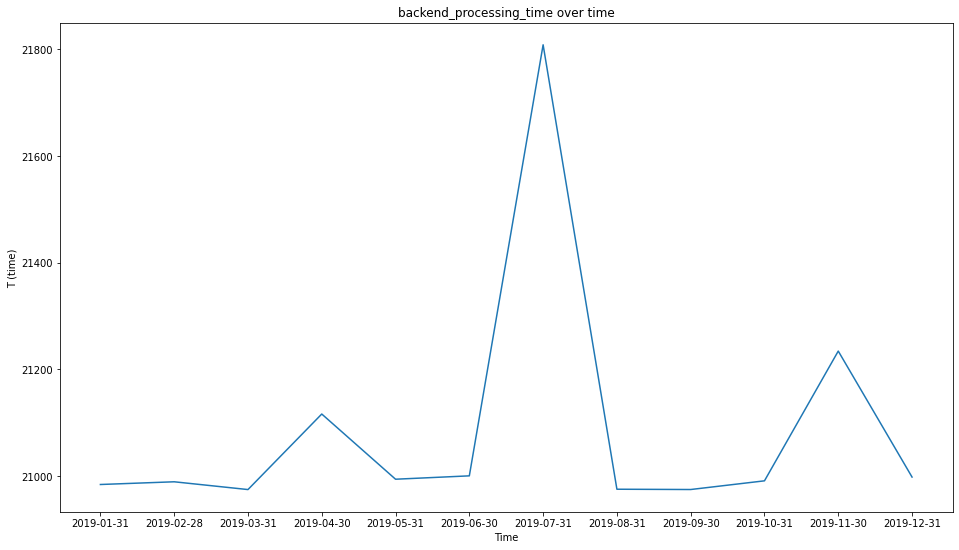

In [144]:
plt.figure(figsize=(16,9))
# plt.ylim([0,y_max ])
plt.plot(df_T['ds'], df_T['y'])
#plt.plot(filter_anomaly_log_df_resample['timestamp'], filter_anomaly_log_df_resample['backend_processing_time'], 'o', color='red')
plt.title('backend_processing_time over time')
plt.xlabel('Time')
plt.ylabel('T (time)')
plt.show()

## Load or define outlier detector

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in ```fetch_detector``` function which saves the pre-trained models in a local directory ```filepath``` and loads the detector. Alternatively, you can train a detector from scratch:

In [41]:
load_outlier_detector = False

In [42]:
filepath = 'my_path'  # change to directory where model is downloaded
if load_outlier_detector:  # load pretrained outlier detector
    detector_type = 'outlier'
    dataset = 'weather'
    detector_name = 'OutlierProphet'
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
    filepath = os.path.join(filepath, detector_name)
else:  # initialize, fit and save outlier detector
    od = OutlierProphet(yearly_seasonality = True, weekly_seasonality= True, daily_seasonality = True, threshold=.9)
    od.fit(df_T)
    save_detector(od, filepath)

Please check out the [documentation](https://docs.seldon.io/projects/alibi-detect/en/latest/methods/prophet.html) as well as the original [Prophet documentation](https://facebook.github.io/prophet/) on how to customize the Prophet-based outlier detector and add seasonalities, holidays, opt for a saturating logistic growth model or apply parameter regularization.

## Predict outliers on test data

Define the test data. It is important that the timestamps of the test data follow the training data. We check this below by comparing the first few rows of the test DataFrame with the last few of the training DataFrame:

In [43]:
n_periods = 4000
d = {'ds': df['timestamp'], 
     'y': df['backend_processing_time']}
df_T_test = pd.DataFrame(data=d)
df_T_test.head()

,ds,y
0,2019-01-01 00:00:00,19052.666667
1,2019-01-01 00:15:00,21883.333333
2,2019-01-01 00:30:00,19024.666667
3,2019-01-01 00:45:00,22486.000000
4,2019-01-01 01:00:00,20256.000000


In [44]:
df_T.tail()

,ds,y
34035,2019-12-21 12:45:00,21781.333333
34036,2019-12-21 13:00:00,21523.333333
34037,2019-12-21 13:15:00,21544.000000
34038,2019-12-21 13:30:00,22649.333333
34039,2019-12-21 13:45:00,20992.000000


Predict outliers on test data:

In [45]:
od_preds = od.predict(
    df_T_test, 
    return_instance_score=True,
    return_forecast=True
)

## Visualize results

We can first visualize our predictions with Prophet's built in plotting functionality. This also allows us to include historical predictions:

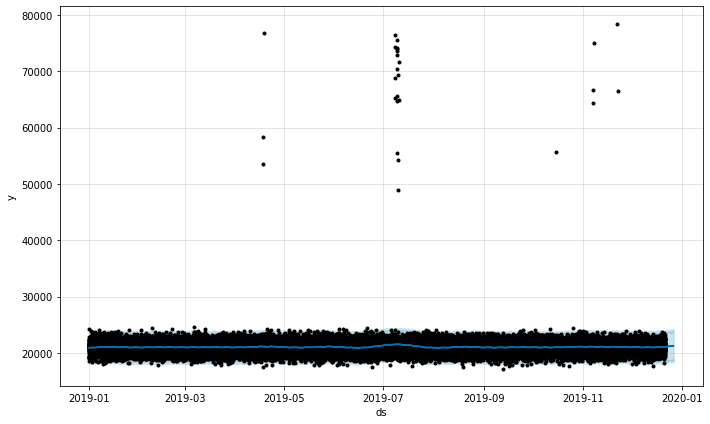

In [46]:
future = od.model.make_future_dataframe(periods=500, freq='15T', include_history=True)
forecast = od.model.predict(future)
fig = od.model.plot(forecast)

We can also plot the breakdown of the different components in the forecast. Since we did not do full Bayesian inference with `mcmc_samples`, the uncertaintly intervals of the forecast are determined by the [MAP estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) of the extrapolated trend.

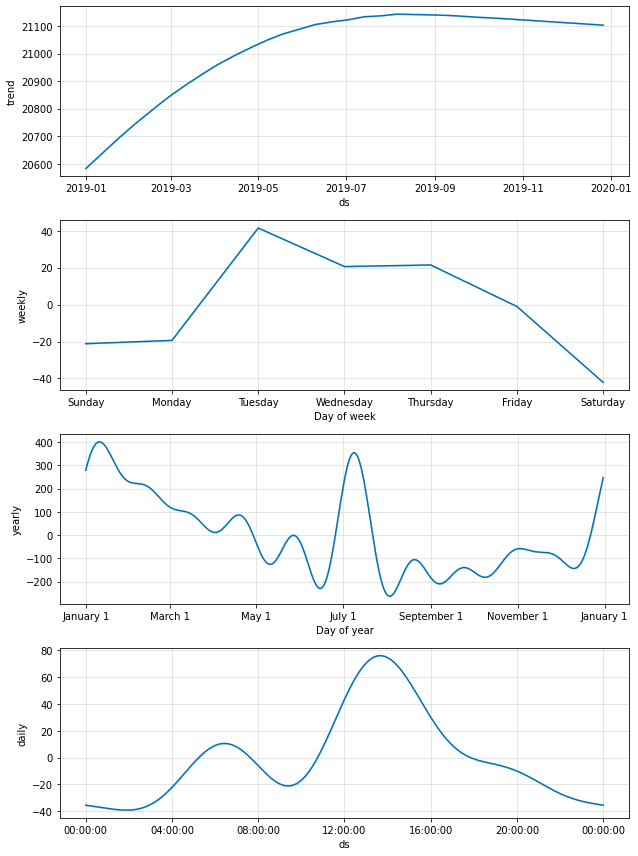

In [47]:
fig = od.model.plot_components(forecast)

It is clear that the further we predict in the future, the wider the uncertainty intervals which determine the outlier threshold.

Let's overlay the actual data with the upper and lower outlier thresholds predictions and check where we predicted outliers:

In [48]:
forecast['y'] = df['backend_processing_time'][:n_prophet+n_periods]

In [49]:
forecast[['ds', 'yhat', 'y']]

,ds,yhat,y
0,2019-01-01 00:00:00,20855.463577,19052.666667
1,2019-01-01 00:15:00,20855.542626,21883.333333
2,2019-01-01 00:30:00,20855.608422,19024.666667
3,2019-01-01 00:45:00,20855.656284,22486.000000
4,2019-01-01 01:00:00,20855.700793,20256.000000
...,...,...,...
34535,2019-12-26 17:45:00,21231.761094,20068.666667
34536,2019-12-26 18:00:00,21229.842487,20886.000000
34537,2019-12-26 18:15:00,21228.305269,21652.000000
34538,2019-12-26 18:30:00,21227.020158,21328.666667


In [50]:
# forecast = forecast[forecast['ds'].dt.date.astype(str) == '2019-12-01']
# test_fc = forecast[forecast['ds'].dt.date.astype(str) == '2019-11-01']
# rangeDate = (forecast['ds'] > '2019-03-01 00:00:00' ) & (forecast['ds'] <= '2019-03-31 00:00:00' )
test_fc   = forecast

In [51]:
test_fc[['ds', 'yhat_upper', 'y']]

,ds,yhat_upper,y
0,2019-01-01 00:00:00,23586.322229,19052.666667
1,2019-01-01 00:15:00,23500.825920,21883.333333
2,2019-01-01 00:30:00,23560.859181,19024.666667
3,2019-01-01 00:45:00,23553.277649,22486.000000
4,2019-01-01 01:00:00,23325.333048,20256.000000
...,...,...,...
34535,2019-12-26 17:45:00,23824.671556,20068.666667
34536,2019-12-26 18:00:00,23706.681197,20886.000000
34537,2019-12-26 18:15:00,23887.954308,21652.000000
34538,2019-12-26 18:30:00,24115.041185,21328.666667


In [52]:
test_fc['y'].max()

78481.07438016529

In [74]:
fc_df = forecast[['ds', 'y' ,'yhat', 'yhat_lower', 'yhat_upper']]
fc_df.index = fc_df.ds
fc_df

,ds,y,yhat,yhat_lower,yhat_upper
ds,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,19052.666667,20855.463577,18237.011519,23586.322229
2019-01-01 00:15:00,2019-01-01 00:15:00,21883.333333,20855.542626,18210.145946,23500.825920
2019-01-01 00:30:00,2019-01-01 00:30:00,19024.666667,20855.608422,18176.704454,23560.859181
2019-01-01 00:45:00,2019-01-01 00:45:00,22486.000000,20855.656284,18071.264631,23553.277649
2019-01-01 01:00:00,2019-01-01 01:00:00,20256.000000,20855.700793,18404.023906,23325.333048
...,...,...,...,...,...
2019-12-26 17:45:00,2019-12-26 17:45:00,20068.666667,21231.761094,18555.016556,23824.671556
2019-12-26 18:00:00,2019-12-26 18:00:00,20886.000000,21229.842487,18700.563444,23706.681197
2019-12-26 18:15:00,2019-12-26 18:15:00,21652.000000,21228.305269,18634.439552,23887.954308


In [75]:
ano_df = filter_anomaly_log_df_resample 
ano_df.index = ano_df.timestamp
ano_df


,backend_processing_time,timestamp
timestamp,,
2019-04-18 06:00:00,95618.571429,2019-04-18 06:00:00
2019-04-18 06:15:00,NaN,2019-04-18 06:15:00
2019-04-18 06:30:00,NaN,2019-04-18 06:30:00
2019-04-18 06:45:00,NaN,2019-04-18 06:45:00
2019-04-18 07:00:00,92410.312500,2019-04-18 07:00:00
...,...,...
2019-11-22 15:00:00,NaN,2019-11-22 15:00:00
2019-11-22 15:15:00,NaN,2019-11-22 15:15:00
2019-11-22 15:30:00,NaN,2019-11-22 15:30:00


In [106]:
test = fc_df.join(ano_df)
#test = test[(test['timestamp'] > '2019-04-01') & (test['timestamp'] <= '2019-04-19')]
test


,ds,y,yhat,yhat_lower,yhat_upper,backend_processing_time,timestamp
ds,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,19052.666667,20855.463577,18237.011519,23586.322229,NaN,NaN
2019-01-01 00:15:00,2019-01-01 00:15:00,21883.333333,20855.542626,18210.145946,23500.825920,NaN,NaN
2019-01-01 00:30:00,2019-01-01 00:30:00,19024.666667,20855.608422,18176.704454,23560.859181,NaN,NaN
2019-01-01 00:45:00,2019-01-01 00:45:00,22486.000000,20855.656284,18071.264631,23553.277649,NaN,NaN
2019-01-01 01:00:00,2019-01-01 01:00:00,20256.000000,20855.700793,18404.023906,23325.333048,NaN,NaN
...,...,...,...,...,...,...,...
2019-12-26 17:45:00,2019-12-26 17:45:00,20068.666667,21231.761094,18555.016556,23824.671556,NaN,NaN
2019-12-26 18:00:00,2019-12-26 18:00:00,20886.000000,21229.842487,18700.563444,23706.681197,NaN,NaN
2019-12-26 18:15:00,2019-12-26 18:15:00,21652.000000,21228.305269,18634.439552,23887.954308,NaN,NaN


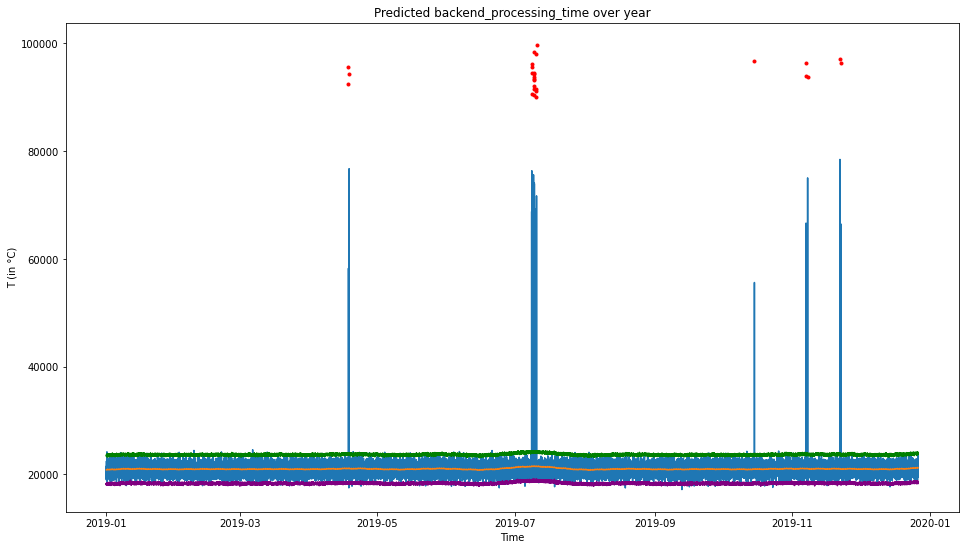

In [104]:
pd.plotting.register_matplotlib_converters()  # needed to plot timestamps
#test.plot(x='ds', y=['y'])
#test.plot(x='ds', y=['y', 'yhat', 'yhat_upper', 'yhat_lower'])
plt.figure(figsize=(16,9))
plt.plot(test['ds'],test['y'])
plt.plot(test['ds'], test['backend_processing_time'], '.', color='red')
plt.plot(test['ds'],test['yhat'])
plt.plot(test['ds'],test['yhat_upper'], color='green')
plt.plot(test['ds'],test['yhat_lower'], color='purple')

plt.title('Predicted backend_processing_time over year')
plt.xlabel('Time')
plt.ylabel('T')
plt.show()

Outlier scores and predictions:

In [ ]:
od_preds['data']['forecast']['threshold'] = np.zeros(35040)
od_preds['data']['forecast'][-35040:].plot(x='ds', y=['score', 'threshold'])
plt.title('Outlier score over time')
plt.xlabel('Time')
plt.ylabel('Outlier score')
plt.show()

The outlier scores naturally trend down as uncertainty increases when we predict further in the future.

Let's look at some individual outliers:

In [ ]:
df_fcst = od_preds['data']['forecast']
df_outlier = df_fcst

In [ ]:
print('Number of outliers: {}'.format(df_outlier.shape[0]))
df_outlier = df_outlier[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
pred_data = df_outlier.head(34540)

In [ ]:
fc_data = forecast['y']

In [ ]:
pred_data = pd.concat([pred_data, fc_data], axis=1)

In [ ]:
pred_data

In [ ]:
pred_data.to_csv('Predict_2019_0.3_3', header=None)

In [ ]:
results = pd.read_csv('results_2019.csv', sep=',', header=None, encoding='utf-8', index_col= None, names=['datetime', 'yhat', 'yhat_lower', 'yhat_upper', 'y'])

In [ ]:
results

In [ ]:
year_df = results
year_anomaly = filter_anomaly_log_df

plt.plot(year_anomaly['timestamp'], year_anomaly['backend_processing_time'], 'o', color='red')
plt.plot(year_df['datetime'], year_df['yhat_upper'])

plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (results['datetime'] > '2019-01-01 00:00:00') & (results['datetime'] <= '2019-01-31 00:00:00')
rangeDate_anomaly = (filter_anomaly_log_df['timestamp'] > '2019-01-01 00:00:00') & (filter_anomaly_log_df['timestamp'] <= '2019-01-31 00:00:00')

jan_df = results.loc[rangeDate]
jan_anomaly = filter_anomaly_log_df.loc[rangeDate_anomaly]

plt.plot(filter_anomaly_log_df['timestamp'], filter_anomaly_log_df['backend_processing_time'], 'o', color='black')
plt.plot(jan_df['datetime'], jan_df['yhat_upper'])

plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-02-01 00:00:00') & (forecast['ds'] <= '2019-02-28 00:00:00')
feb_df = forecast.loc[rangeDate]
feb_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-03-01 00:00:00') & (forecast['ds'] <= '2019-03-03 00:00:00')
march_df = forecast.loc[rangeDate]
march_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-04-01 00:00:00') & (forecast['ds'] <= '2019-04-30 00:00:00')
apr_df = forecast.loc[rangeDate]
apr_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (results['datetime'] > '2019-05-01 00:00:00') & (results['datetime'] <= '2019-05-31 00:00:00')
may_df = results.loc[rangeDate]
may_df.plot(x='datetime', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-06-01 00:00:00') & (forecast['ds'] <= '2019-06-30 00:00:00')
jun_df = forecast.loc[rangeDate]
jun_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (results['datetime'] > '2019-07-01 00:00:00') & (results['datetime'] <= '2019-07-31 00:00:00')
jul_df = results.loc[rangeDate]
jul_df.plot(x='datetime', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-08-01 00:00:00') & (forecast['ds'] <= '2019-08-30 00:00:00')
aug_df = forecast.loc[rangeDate]
aug_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-09-01 00:00:00') & (forecast['ds'] <= '2019-09-30 00:00:00')
sep_df = forecast.loc[rangeDate]
sep_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-10-01 00:00:00') & (forecast['ds'] <= '2019-10-31 00:00:00')
oct_df = forecast.loc[rangeDate]
oct_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-11-01 00:00:00') & (forecast['ds'] <= '2019-11-30 00:00:00')
nov_df = forecast.loc[rangeDate]
nov_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()

In [ ]:
rangeDate = (forecast['ds'] > '2019-12-01 00:00:00') & (forecast['ds'] <= '2019-12-31 00:00:00')
dec_df = forecast.loc[rangeDate]
dec_df.plot(x='ds', y=['y','yhat_upper'])
plt.title('Predicted yhat_upper over time')
plt.xlabel('Time')
plt.ylabel('backend Proccesing time')
plt.show()